# Setup

In [20]:
import os 
import sys 
sys.path.append(r"C:\Users\nguye\Documents\HKVI\NLP\NLP-N2-IR\KHDL2211_N2\preprocessing")

import pandas as pd
import polars as pl 
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from nlp_tools import NLP_Preprocessing

from sklearn.feature_extraction.text import (CountVectorizer, 
                                             TfidfVectorizer)
from sklearn.preprocessing import (LabelEncoder,
                                   OneHotEncoder)
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (confusion_matrix)

from tensorflow import keras
from keras import layers

In [21]:
tools = NLP_Preprocessing()

In [24]:
data = pl.read_csv(r"..\..\dataset.csv")

In [25]:
data.head()

app_id,app_name,review_text,review_score,review_votes
i64,str,str,i64,i64
10,"""Counter-Strike""","""Ruined my life.""",1,0
10,"""Counter-Strike""","""This will be more of a ''my ex…",1,1
10,"""Counter-Strike""","""This game saved my virginity.""",1,0
10,"""Counter-Strike""","""• Do you like original games? …",1,0
10,"""Counter-Strike""",""" Easy to learn, hard to…",1,1


In [26]:
data.shape

(6417106, 5)

In [27]:
data["review_score"].value_counts()["review_score"]

review_score
i64
-1
1


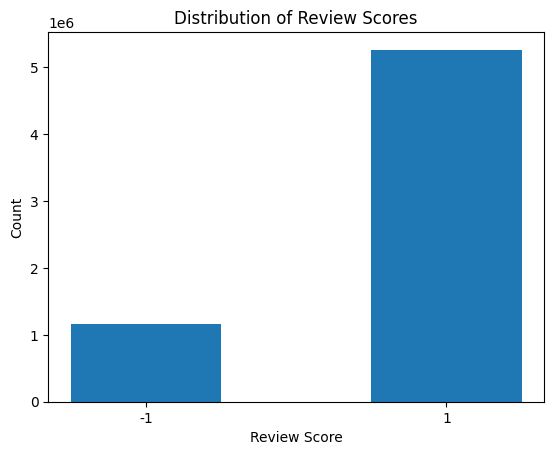

In [28]:
value_counts = data["review_score"].value_counts()
cols = value_counts["review_score"].to_numpy().astype(str)
counts = value_counts["count"].to_numpy() 

plt.bar(cols, counts, width=0.5)
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.title("Distribution of Review Scores")
plt.show()

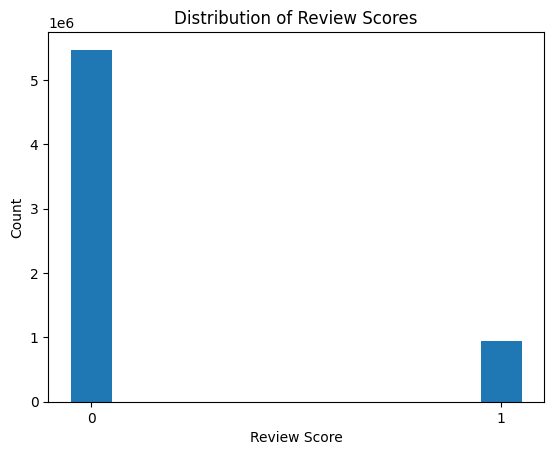

In [29]:
value_counts = data["review_votes"].value_counts()
cols = value_counts["review_votes"].to_numpy().astype(str)
counts = value_counts["count"].to_numpy() 

plt.bar(cols, counts, width=0.1)
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.title("Distribution of Review Scores")
plt.show()

# Tiền xử lý dữ liệu

In [30]:
data.null_count()

app_id,app_name,review_text,review_score,review_votes
u32,u32,u32,u32,u32
0,183234,7305,0,0


In [31]:
data.null_count()*100/len(data)

app_id,app_name,review_text,review_score,review_votes
f64,f64,f64,f64,f64
0.0,2.855399,0.113836,0.0,0.0


In [32]:
data["review_text"].null_count()/len(data)

0.0011383636174936177

In [33]:
data = data[:, ["review_text", "review_votes"]]

In [34]:
data = data.drop_nulls()

In [35]:
data.null_count()*100/len(data)

review_text,review_votes
f64,f64
0.0,0.0


In [36]:
data = data.unique()

In [37]:
data.shape

(4483987, 2)

# Chọn dữ liệu nhỏ hơn

In [38]:
n_sample = 50

In [39]:
# Tron du lieu dam bao tinh ngau nhien
shuffled_data = data.sample(fraction=1, shuffle=True, seed=42)

In [40]:
# Lay n phan tu cua tieu cuc
votes_0 = shuffled_data.filter(pl.col("review_votes") == 0)
votes_0 = votes_0.head(n_sample)
votes_0.head()

review_text,review_votes
str,i64
"""tome raider has more cons than…",0
"""From what little I played I wo…",0
"""you see ivan this is a good ga…",0
"""my favorite part is the seagul…",0
"""Took awhile to get up to scrat…",0


In [41]:
votes_1 = shuffled_data.filter(pl.col("review_votes") == 1)
votes_1 = votes_1.head(n_sample)
votes_1.head()

review_text,review_votes
str,i64
"""1 2 3 4 5 6 7 8 9 we still thi…",1
"""Usually not my kind of Game, b…",1
"""Here's basically how this game…",1
"""I think the negative reviews a…",1
"""Don't buy it, if you live a ha…",1


In [42]:
small_data = pl.concat([votes_0, votes_1])
print(small_data["review_votes"].unique())
small_data.shape

shape: (2,)
Series: 'review_votes' [i64]
[
	0
	1
]


(100, 2)

In [43]:
docs = small_data["review_text"]
labels = small_data["review_votes"]

In [44]:
tokens = tools.preprocess(docs)
docs = tools.get_corpus(tokens)

In [45]:
print(tokens[0])
print(docs[0])

['raider', 'con', 'pro', 'good', 'thing', 'lot', 'stori', 'plot', 'charact', 'ai', 'amaz', 'bad', 'thing', 'enough', 'hour', 'dollar', 'game', 'tomb', 'hard', 'game', 'bit', 'easi', 'hard', 'suck', 'last', 'bad']
raider con pro good thing lot stori plot charact ai amaz bad thing enough hour dollar game tomb hard game bit easi hard suck last bad


# TF-IDF

In [46]:
X = docs
y = labels.to_numpy()

In [47]:
tfidf_vectorizer = TfidfVectorizer(norm="l2")
X = tfidf_vectorizer.fit_transform(X)
X.shape

(100, 1299)

In [48]:
X = X.toarray()

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)

<Axes: >

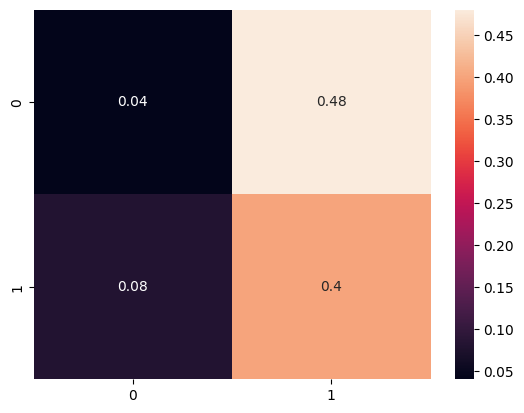

In [50]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
nb_cfs_mtx = confusion_matrix(y_test, y_pred)

sns.heatmap(nb_cfs_mtx/np.sum(nb_cfs_mtx), annot=True)